In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print("Available GPUs:", get_available_gpus())

Available GPUs: ['/device:GPU:0']


In [2]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from math import log2
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x)
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    shape = (
        cf["image_size"]//cf["patch_size"],
        cf["image_size"]//cf["patch_size"],
        cf["hidden_dim"]
    )
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)

    ## Additional layers for managing different patch sizes
    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2: ## Patch size 16 or greater
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)
        # print(z3.shape, z6.shape, z9.shape, z12.shape)

    if upscale < 0: ## Patch size less than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    ## Decoder 1
    x = deconv_block(z12, 128)

    s = deconv_block(z9, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])

    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 2
    x = deconv_block(x, 64)

    s = deconv_block(z6, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    ## Decoder 3
    x = deconv_block(x, 32)

    s = deconv_block(z3, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 32)
    x = conv_block(x, 32)

    ## Decoder 4
    x = deconv_block(x, 16)

    s = conv_block(z0, 16)
    s = conv_block(s, 16)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 16)
    x = conv_block(x, 16)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")

# if __name__ == "__main__":
#     config = {}
#     config["image_size"] = 512
#     config["num_layers"] = 12
#     config["hidden_dim"] = 768
#     config["mlp_dim"] = 3092
#     config["num_heads"] = 6
#     config["dropout_rate"] = 0.1
#     config["patch_size"] = 16
#     config["num_patches"] = (config["image_size"]**2)//(config["patch_size"]**2)
#     config["num_channels"] = 3

#     model = build_unetr_2d(config)
#     model.summary()


In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from patchify import patchify
import nibabel as nib

cf = {}
cf["image_size"] = 256
cf["num_channels"] = 1
cf["num_layers"] = 12
cf["hidden_dim"] = 768
cf["mlp_dim"] = 3092
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (cf["num_patches"],cf["patch_size"]*cf["patch_size"]*cf["num_channels"])

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# def load_dataset(path, split=0.1):
#     """ Loading the images and masks """
#     X = sorted(glob(os.path.join(path, "images", "*.jpg")))
#     Y = sorted(glob(os.path.join(path, "masks", "*.png")))

#     """ Spliting the data into training and testing """
#     split_size = int(len(X) * split)

#     train_x, valid_x = train_test_split(X, test_size=split_size, random_state=42)
#     train_y, valid_y = train_test_split(Y, test_size=split_size, random_state=42)

#     train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
#     train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

#     return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    #path = path.decode()
    nii_img = nib.load(path)

    image = nii_img.get_fdata()

    num_slices = image.shape[2]
    patches = []

    for i in range(num_slices):
        slice = image[:, :, i]

        # Normalize the pixel values to the range [0, 1]
        slice_normalized = slice / np.max(slice) if np.max(slice) != 0 else slice

        # Resize the slice to the desired size
        slice_resized = cv2.resize(slice_normalized, (cf["image_size"], cf["image_size"]))
        slice_resized = np.expand_dims(slice_resized, axis=-1)
        # Ensure the slice is in float32 format
        # slice_resized = slice_resized.astype(np.float32)

        """ Processing to patches """
        patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
        patch = patchify(slice_resized, patch_shape, cf["patch_size"])
        patch = np.reshape(patch, cf["flat_patches_shape"])
        patch = patch.astype(np.float32)
        patches.append(slice_resized)

    return patches

def read_mask_volume(path):
    """ Reading and processing all slices from a 3D mask volume in a NIfTI file """
    nii_img = nib.load(path)
    masks = nii_img.get_fdata()

    num_slices = masks.shape[2]
    processed_masks = []

    for i in range(num_slices):
        slice = masks[:, :, i]

        # Normalize the mask values to range [0, 1]
        slice_normalized = slice / np.max(slice) if np.max(slice) != 0 else slice

        # Resize the mask using nearest neighbor interpolation
        slice_resized = cv2.resize(slice_normalized, (cf["image_size"], cf["image_size"]), interpolation=cv2.INTER_NEAREST)
        
        # Ensure the mask is in float32 format, could be changed to int if labels are categorical
        slice_resized = slice_resized.astype(np.float32)
        slice_resized = np.expand_dims(slice_resized, axis=-1)
        processed_masks.append(slice_resized)

    return processed_masks



def load_dataset(path, image_size, split=0.1):
    """ Load image and mask volumes from NIfTI files, process them, and split into datasets. """
    image_paths = sorted(glob(os.path.join(path, "images", "*.nii.gz")))
    mask_paths = sorted(glob(os.path.join(path, "masks", "*.nii.gz")))

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        images.extend(read_image(img_path))
        masks.extend(read_mask_volume(mask_path))

    # Splitting the data into training, validation, and testing
    split_size_val = int(len(images) * split)
    split_size_test = int(len(images) * split)

    train_x, valid_x, train_y, valid_y = train_test_split(images, masks, test_size=split_size_val, random_state=42)
    train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=split_size_test, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# Example usage:


# def tf_parse(x, y):
#     # Ensure that the inputs to tf.numpy_function are tensors
#     # Use tf.numpy_function to convert the tensors to numpy arrays and call the _parse function
#     x, y = tf.numpy_function(load_dataset, [x, y], [tf.float32, tf.float32])
#     x.set_shape(cf["flat_patches_shape"])  # Adjust shape as needed
#     y.set_shape([cf["image_size"], cf["image_size"], 1])
#     return x, y

def tf_dataset(X, Y, batch=16):
    # Convert lists of paths to tensor slices for compatibility
    ds = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))
    ds = ds.batch(batch).prefetch(10)
    return ds


if __name__ == "__main__":
    
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Hyperparameters """
    batch_size = 2
    lr = 0.1
    num_epochs = 500
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")
    image_size = 256  # Set this to the desired size for your model
    
    """ Dataset """
    path = "D:\\Anik\\UNETR"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(path, image_size)

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
    
    """Metrics"""
    smooth = 1e-15
    def dice_coef(y_true, y_pred):
        y_true = tf.keras.layers.Flatten()(y_true)
        y_pred = tf.keras.layers.Flatten()(y_pred)
        intersection = tf.reduce_sum(y_true * y_pred)
        return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

    def dice_loss(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred)

    """ Model """
    model = build_unetr_2d(cf)
    model.compile(loss=dice_loss, optimizer=SGD(lr))
    # model.summary()

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False)
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/500
405/405 [==============================] - ETA: 0s - loss: 0.9658
Epoch 1: val_loss improved from inf to 0.97285, saving model to files\model.h5
405/405 [==============================] - 112s 215ms/step - loss: 0.9658 - val_loss: 0.9728 - lr: 0.1000
Epoch 2/500
405/405 [==============================] - ETA: 0s - loss: 0.9251
Epoch 2: val_loss improved from 0.97285 to 0.84779, saving model to files\model.h5
405/405 [==============================] - 138s 341ms/step - loss: 0.9251 - val_loss: 0.8478 - lr: 0.1000
Epoch 3/500
405/405 [==============================] - ETA: 0s - loss: 0.7429
Epoch 3: val_loss improved from 0.84779 to 0.79055, saving model to files\model.h5
405/405 [==============================] - 234s 577ms/step - loss: 0.7429 - val_loss: 0.7905 - lr: 0.1000
Epoch 4/500
405/405 [==============================] - ETA: 0s - loss: 0.6416
Epoch 4: val_loss improved from 0.79055 to 0.75572, saving model to files\model.h5
405/405 [==============================] -

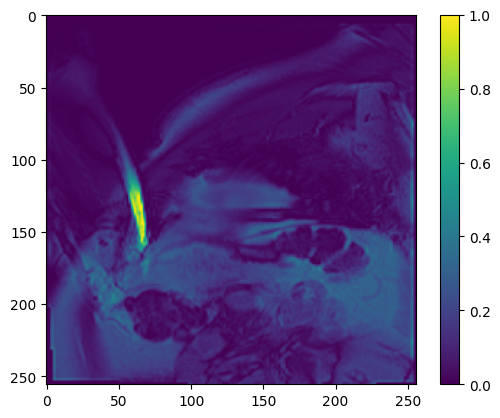

In [52]:
import matplotlib.pyplot as plt 

plt.imshow(img_slices[0],cmap='viridis')
plt.colorbar()  # Optionally add a colorbar to see the image intensity scale
plt.show()

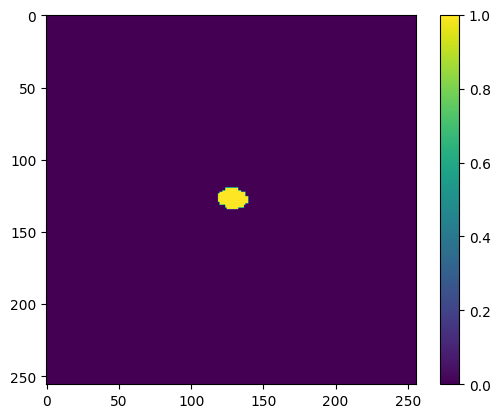

In [51]:
import matplotlib.pyplot as plt 

plt.imshow(mask_slices[0],cmap='viridis')
plt.colorbar()  # Optionally add a colorbar to see the image intensity scale
plt.show()

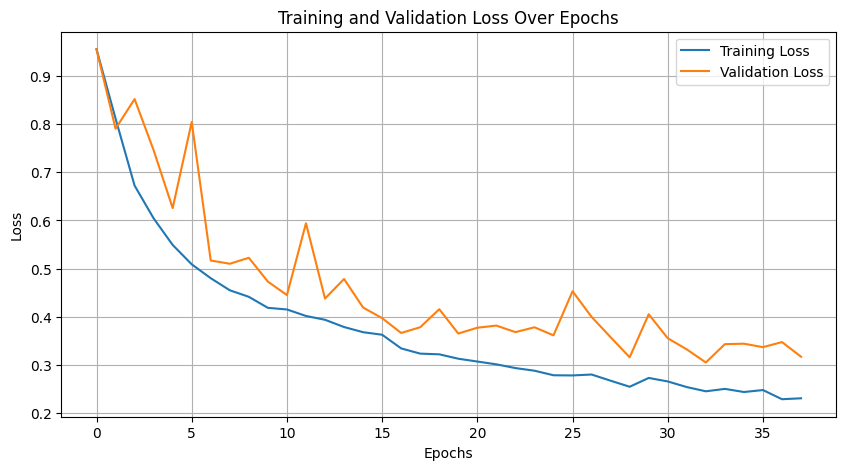

In [24]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(38))
loss = [
    0.95595782995224, 0.8118369579315186, 0.6724292039871216, 0.604293704032898, 0.5490157604217529,
    0.5087303519248962, 0.4798375368118286, 0.4547554850578308, 0.44114768505096436, 0.41823700070381165,
    0.41488316655158997, 0.401358962059021, 0.3934403955936432, 0.3783453404903412, 0.36761772632598877,
    0.36231672763824463, 0.3339105546474457, 0.32305580377578735, 0.32159513235092163, 0.31248536705970764,
    0.3066045939922333, 0.3007888197898865, 0.29301387071609497, 0.2875311076641083, 0.27808451652526855,
    0.2777046859264374, 0.27961599826812744, 0.2667354345321655, 0.2541729211807251, 0.2725008428096771,
    0.26520389318466187, 0.25351524353027344, 0.24471987783908844, 0.24974213540554047, 0.24325229227542877,
    0.24729616940021515, 0.22825446724891663, 0.2301916778087616
]
val_loss = [
    0.9557009339332581, 0.7906922698020935, 0.8522740006446838, 0.74596107006073, 0.6256158947944641,
    0.8047217726707458, 0.5166072249412537, 0.5099542140960693, 0.5222723484039307, 0.47278517484664917,
    0.44482994079589844, 0.5941042304039001, 0.43760907649993896, 0.4782409369945526, 0.41888749599456787,
    0.3968437612056732, 0.36601513624191284, 0.37796035408973694, 0.4153710901737213, 0.3648230731487274,
    0.37692558765411377, 0.38132667541503906, 0.3677617609500885, 0.377813458442688, 0.36107170581817627,
    0.4527398943901062, 0.3994012773036957, 0.35716792941093445, 0.315464586019516, 0.40488776564598083,
    0.35504817962646484, 0.3318232297897339, 0.3046281337738037, 0.34278884530067444, 0.3436652421951294,
    0.3365333080291748, 0.3470798432826996, 0.3166030943393707
]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [5]:
predictions = model.predict(test_dataset)

50/50 [==============================] - 5s 62ms/step


1/1 [==============================] - 3s 3s/step


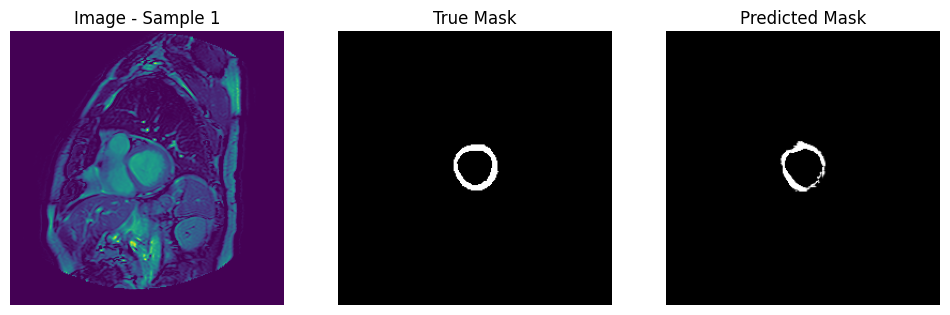

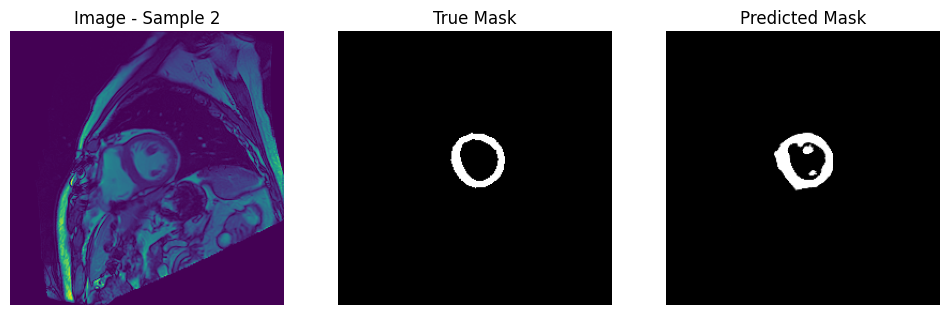

1/1 [==============================] - 0s 95ms/step


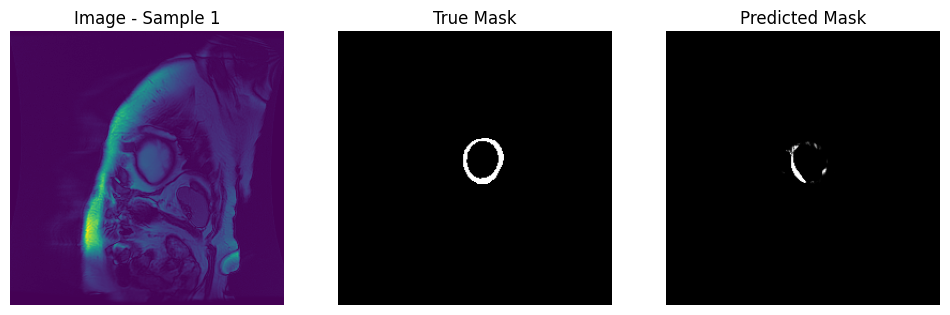

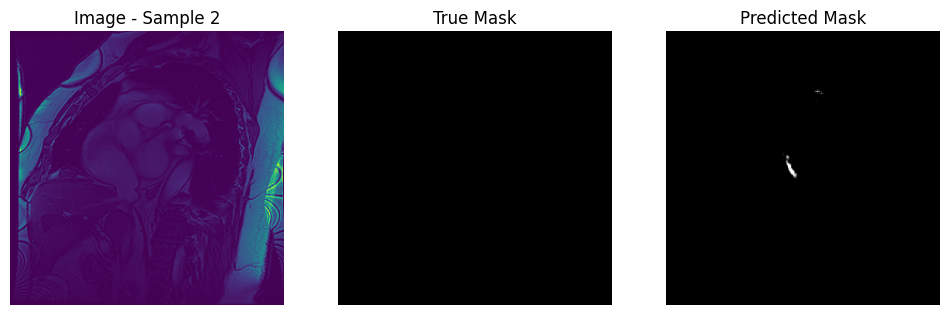

1/1 [==============================] - 0s 86ms/step


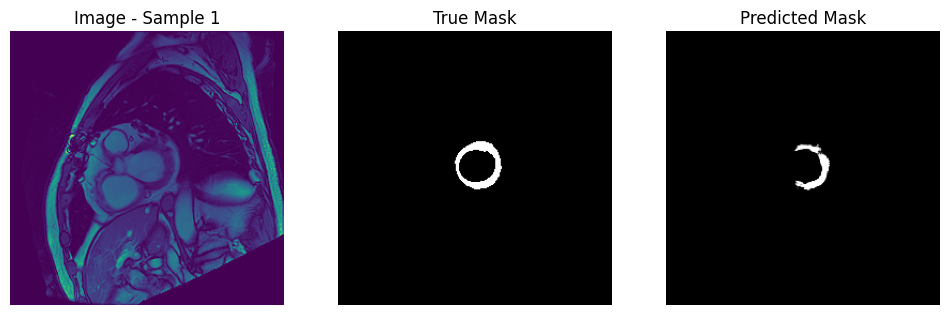

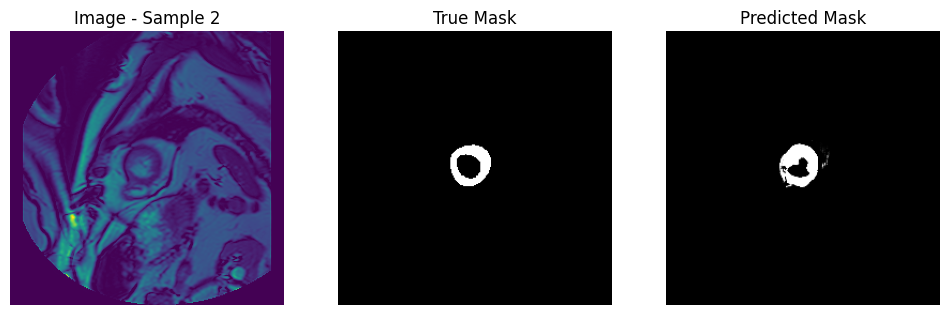

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a single sample
def plot_sample(image, true_mask, predicted_mask, index, sample_index):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.title(f'Image - Sample {sample_index + 1}')
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')
    
    plt.show()

# Function to plot samples from a batch
def plot_batch(batch, predictions, batch_index):
    images, true_masks = batch
    # Convert TensorFlow tensors to numpy arrays if not already
    images = images.numpy() if hasattr(images, 'numpy') else images
    true_masks = true_masks.numpy() if hasattr(true_masks, 'numpy') else true_masks
    predictions = predictions.numpy() if hasattr(predictions, 'numpy') else predictions
    
    # Iterate over each sample in the batch
    for i in range(images.shape[0]):  # Assumes images is a batched tensor
        plot_sample(images[i], true_masks[i], predictions[i], batch_index, i)

# Example of how to use plot_batch
# Iterate over batches in the test_dataset
num_batches = 3  # You can adjust this to the number of batches you want to plot
for i, batch in enumerate(test_dataset.take(num_batches)):
    # Get predictions for the current batch
    current_predictions = model.predict(batch[0])  # Assuming batch[0] are the images
    plot_batch(batch, current_predictions, i)
